# K9 signal 5 tissue

In [37]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [38]:
def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


def scan_bw_signal_split2bins(bw_scan, name, capture_regions_file, bigwig_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'

    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                    sep='\t',
                                    header=None,
                                    index_col=None,
                                    names=xticks) / mean     
    return signal

In [39]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment': ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis': ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment': ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment': ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [40]:
### non-universal CHM

os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table/signal_K9')
signal_AB_dict_nonUni = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict_nonUni[end] = {}
    for compart in ['A', 'B'] :
        bed_fi = f'../intersectOnly_Universal_complementarySetCHM_5tissue_{compart}.{end}.bed' if end != 'body' else f'../intersectOnly_Universal_complementarySetCHM_5tissue_{compart}.bed'
        bw_scan = False if end != '5end' else False
#             resolution = 100 if end == 'body' else 500
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict_nonUni[end][compart] = scan_bw_signal_split2bins(
            bw_scan = bw_scan,
            name = f'K9_around_nonUniversalCHM_{compart}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            bigwig_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/MethK9Signal/{process}_{stage}.H3K9me3.rmDup.bw' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_H3K9me3_nonUniversalCHM' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [28]:
### universal CHM

os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table/signal_K9')
signal_AB_dict_uni = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict_uni[end] = {}
    for compart in ['A', 'B'] :
        bed_fi = f'../intersectOnly_UniversalCHM_5tissue_{compart}.{end}.bed' if end != 'body' else f'../intersectOnly_UniversalCHM_5tissue_{compart}.bed'
        bw_scan = False if end != '5end' else False
#             resolution = 100 if end == 'body' else 500
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict_uni[end][compart] = scan_bw_signal_split2bins(
            bw_scan = bw_scan,
            name = f'K9_around_CHM_{compart}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            bigwig_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/MethK9Signal/{process}_{stage}.H3K9me3.rmDup.bw' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [41]:
### nonCHM

os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/nonCHM_intersect_table/signal_K9')
signal_AB_dict_nonCHM = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict_nonCHM[end] = {}
    for compart in ['A', 'B'] :
        bed_fi = f'../intersectOnly_nonCHM_5tissue_{compart}.{end}.bed' if end != 'body' else f'../intersectOnly_nonCHM_5tissue_{compart}.bed'
        bw_scan = True if end != '5end' else True
#             resolution = 100 if end == 'body' else 500
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict_nonCHM[end][compart] = scan_bw_signal_split2bins(
            bw_scan = bw_scan,
            name = f'K9_around_nonCHM_{compart}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            bigwig_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/MethK9Signal/{process}_{stage}.H3K9me3.rmDup.bw' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_H3K9me3_nonCHM' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [29]:
### non-universa CHM

signal_AB_concat_dict_nonUni = {}
# for span in [5000, 10000, 50000, 100000, 500000, 1000000, 2000000] :
for span in [50000, 100000] :
    signal_AB_concat_dict_nonUni[span] = {}
    for process in signal_AB_dict_nonUni.keys() :
        for label in signal_AB_dict_nonUni['body']['A'].keys() :
            signal_AB_concat_dict_nonUni[span][label] = {}
            for compart in ['A', 'B'] :
                signal_AB_concat_dict_nonUni[span][label][compart] = pd.concat([signal_AB_dict_nonUni['5end'][compart][label][np.arange(-span, 0, 100)], 
                                                                         signal_AB_dict_nonUni['body'][compart][label], 
                                                                         signal_AB_dict_nonUni['3end'][compart][label][np.arange(100, span+100, 100)]], axis = 1)
                body_len = signal_AB_dict_nonUni['body'][compart][label].columns[-1] - signal_AB_dict_nonUni['body'][compart][label].columns[0]
                signal_AB_concat_dict_nonUni[span][label][compart].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict_nonUni['body'][compart][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
        
signal_AB_concat_dict_nonUni[span][label][compart]

,-100000,-99900,-99800,-99700,-99600,-99500,-99400,-99300,-99200,-99100,...,104100,104200,104300,104400,104500,104600,104700,104800,104900,105000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.633553,0.582563,0.636103,0.470385,0.221807,0.563442,0.820942,0.604234,0.312315,0.386213
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.352580,1.019804,1.074655,1.592306,1.691729,1.782247,1.547663,0.935670,1.463532,1.666140
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.900791,2.057592,1.476252,1.388292,1.863821,1.768214,1.321964,1.496659,1.856175,2.521873
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.566811,1.339832,0.810744,0.461461,0.224357,0.449989,0.778875,1.411242,1.347505,0.538931
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.157483,1.232688,1.239094,1.179158,1.515780,0.917824,0.708764,1.240393,1.347505,0.998365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6024,1.158759,0.803096,0.721511,1.425262,1.597408,0.979024,0.495880,0.480583,0.673071,0.624630,...,0.804371,0.625905,0.365855,0.360756,0.550694,1.001958,1.032552,0.764853,1.009608,1.379588
6025,4.417295,4.705387,4.384141,3.422852,2.803323,1.983650,1.042791,0.601684,0.434692,1.364069,...,2.148097,1.467321,0.781425,0.356931,0.467835,0.673071,0.623355,0.367130,0.446164,1.134673
6026,0.398998,0.420669,0.516276,0.794173,0.739358,0.633553,0.726611,0.423219,0.423219,0.898702,...,0.957341,0.676895,1.015993,1.406154,0.870658,0.133849,0.058639,0.127476,0.188664,0.506115
6027,1.129433,1.147280,1.128168,1.181721,1.138356,1.258196,1.341131,1.208484,1.381931,1.455832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
### universal CHMs

signal_AB_concat_dict_uni = {}
# for span in [5000, 10000, 50000, 100000, 500000, 1000000, 2000000] :
for span in [50000, 100000] :
    signal_AB_concat_dict_uni[span] = {}
    for process in signal_AB_dict_uni.keys() :
        for label in signal_AB_dict_uni['body']['A'].keys() :
            signal_AB_concat_dict_uni[span][label] = {}
            for compart in ['A', 'B'] :
                signal_AB_concat_dict_uni[span][label][compart] = pd.concat([signal_AB_dict_uni['5end'][compart][label][np.arange(-span, 0, 100)], 
                                                                         signal_AB_dict_uni['body'][compart][label], 
                                                                         signal_AB_dict_uni['3end'][compart][label][np.arange(100, span+100, 100)]], axis = 1)
                body_len = signal_AB_dict_uni['body'][compart][label].columns[-1] - signal_AB_dict_uni['body'][compart][label].columns[0]
                signal_AB_concat_dict_uni[span][label][compart].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict_uni['body'][compart][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
        
signal_AB_concat_dict_uni[span][label][compart]

,-100000,-99900,-99800,-99700,-99600,-99500,-99400,-99300,-99200,-99100,...,104100,104200,104300,104400,104500,104600,104700,104800,104900,105000
0,1.222536,0.660323,0.776326,0.891054,0.763578,0.758479,0.643751,1.129433,1.483925,1.281148,...,2.372451,2.389028,2.071611,1.942864,1.851073,1.649670,1.801368,2.032097,1.559165,1.524779
1,2.095834,1.988752,1.568070,1.411269,1.666234,1.718509,1.540030,1.687913,2.062693,2.522877,...,1.436764,1.472463,1.709578,2.224582,2.767625,2.276844,2.349513,3.559272,3.315770,3.652776
2,2.111126,1.532358,1.309234,1.392121,1.654772,1.946680,1.487768,1.089921,1.356409,1.803913,...,0.987935,0.446164,0.316139,0.610608,0.883405,0.699841,0.309766,0.430867,0.610608,0.773688
3,0.000000,0.000000,0.026770,0.193763,0.495880,1.115419,1.693014,2.327834,2.564936,1.947965,...,0.647576,1.255673,2.125146,2.139179,1.460974,1.245472,1.527283,1.557880,1.811558,1.806243
4,1.004507,0.843888,0.952242,0.860460,1.019819,1.838326,1.616502,0.945868,1.574417,1.965801,...,1.692961,1.551506,2.250077,2.287048,2.176136,2.098378,2.211834,1.805185,1.394679,1.413693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,0.006374,0.247303,0.571090,1.188119,1.325812,0.823492,0.518825,0.271523,0.724061,1.186797,...,2.380097,2.999638,2.805868,2.174864,1.741447,2.004044,1.913539,2.241159,3.124556,2.634204
942,0.000000,0.000000,0.067562,0.360756,0.537947,0.404097,0.159344,0.014022,0.558343,0.980287,...,0.000000,0.349283,0.518825,0.342909,0.750831,1.069520,0.792898,0.718962,0.693467,0.705533
943,0.863009,0.678170,0.808195,0.416845,0.508627,0.739358,0.625905,0.539221,0.769952,0.740633,...,1.670023,1.760568,2.122601,2.302339,2.204188,1.555309,1.351308,0.975188,0.604234,0.697961
944,1.040200,1.292650,1.371728,1.707034,1.524712,1.200874,1.313041,1.884228,1.977277,1.274794,...,0.580014,0.744457,0.500979,0.605509,1.255677,1.241620,0.820942,0.815843,0.972638,1.312659


In [43]:
### nonCHMs

signal_AB_concat_dict_nonCHM = {}
# for span in [5000, 10000, 50000, 100000, 500000, 1000000, 2000000] :
for span in [50000, 100000] :
    signal_AB_concat_dict_nonCHM[span] = {}
    for process in signal_AB_dict_nonCHM.keys() :
        for label in signal_AB_dict_nonCHM['body']['A'].keys() :
            signal_AB_concat_dict_nonCHM[span][label] = {}
            for compart in ['A', 'B'] :
                signal_AB_concat_dict_nonCHM[span][label][compart] = pd.concat([signal_AB_dict_nonCHM['5end'][compart][label][np.arange(-span, 0, 100)], 
                                                                         signal_AB_dict_nonCHM['body'][compart][label], 
                                                                         signal_AB_dict_nonCHM['3end'][compart][label][np.arange(100, span+100, 100)]], axis = 1)
                body_len = signal_AB_dict_nonCHM['body'][compart][label].columns[-1] - signal_AB_dict_nonCHM['body'][compart][label].columns[0]
                signal_AB_concat_dict_nonCHM[span][label][compart].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict_nonCHM['body'][compart][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
        
signal_AB_concat_dict_nonCHM[span][label][compart]

,-100000,-99900,-99800,-99700,-99600,-99500,-99400,-99300,-99200,-99100,...,104100,104200,104300,104400,104500,104600,104700,104800,104900,105000
0,1.699388,1.304134,1.134575,1.387033,1.319451,0.638652,0.326337,0.354382,0.781425,0.982836,...,1.573185,2.016791,1.992582,2.497382,2.516504,2.566222,2.914222,2.120057,2.092005,2.318675
1,0.861735,0.814569,0.866834,0.982836,0.604234,0.769952,1.055497,0.724061,0.952246,1.533670,...,2.191441,2.109854,1.774588,1.821762,2.182510,2.162116,1.896975,2.294693,2.960110,2.728873
2,1.219981,0.829866,0.893603,0.910175,0.919099,1.216133,1.101389,0.685818,0.362031,0.330162,...,2.211834,1.894418,1.524739,1.356409,1.293929,1.320721,0.953517,0.791623,1.592266,1.929942
3,1.579545,1.562968,0.916549,0.312315,0.495880,0.785249,0.803096,1.030002,1.645827,1.449499,...,0.985386,1.264603,1.452069,1.339819,1.237806,1.341091,1.321968,1.235265,1.446954,1.180122
4,1.158753,1.250562,1.268424,1.246733,1.439282,1.778418,1.438010,1.109059,1.212306,1.213576,...,1.110312,1.073344,1.256956,1.638194,1.274787,1.143469,1.204675,1.649643,1.998956,1.274812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,1.321975,1.361511,1.875296,2.089461,1.273521,1.262045,1.232688,0.553244,0.191213,0.137674,...,1.542561,1.376789,0.966265,0.611883,0.523924,1.047849,1.037651,0.401548,0.597860,1.278569
635,1.212328,0.634828,1.023645,1.717224,1.148575,0.611883,0.771227,1.041475,0.933121,0.907626,...,1.671309,1.142181,1.286252,1.035101,0.929297,0.964990,1.028728,1.137083,1.719741,2.099061
636,0.676895,1.092465,1.357681,1.508148,1.452043,1.103942,1.259484,1.358940,1.032552,1.072071,...,0.879581,0.741908,0.706214,0.572365,0.845163,1.208535,1.287542,1.347491,1.174054,0.997092
637,0.920373,0.771227,0.810744,0.667972,0.936945,1.301577,1.309245,0.908901,0.645026,0.693467,...,0.977737,0.961165,0.982836,0.834965,0.545595,0.627180,1.100114,1.254373,1.239077,0.868348


In [45]:
colors_uni = ['#C490C6', '#90ADC6']
colors_nonUni = ['#CDA2F9', '#94B6C8',]
colors_nonCHM = ['#E2C8E3', '#BBCDDC']

In [32]:
12 * 16 + 4

196

In [33]:
stage_3_dict = {
 'EarlyEmbryogenesis': ['2cell', '8cell', 'ICM'],
 'PGCsDevelopment': ['E10.5', 'E13.5_female', 'E13.5_male'],
 'Spermatogenesis': ['US', 'DS', 'RS'],
 'RetinalDevelopment': ['E14.5', 'P0', 'P21'],
 'HeartDevelopment': ['E10.5', 'E13.5', 'P0'],
 'LiverDevelopment': ['E11.5', 'E14.5', 'P0']
}

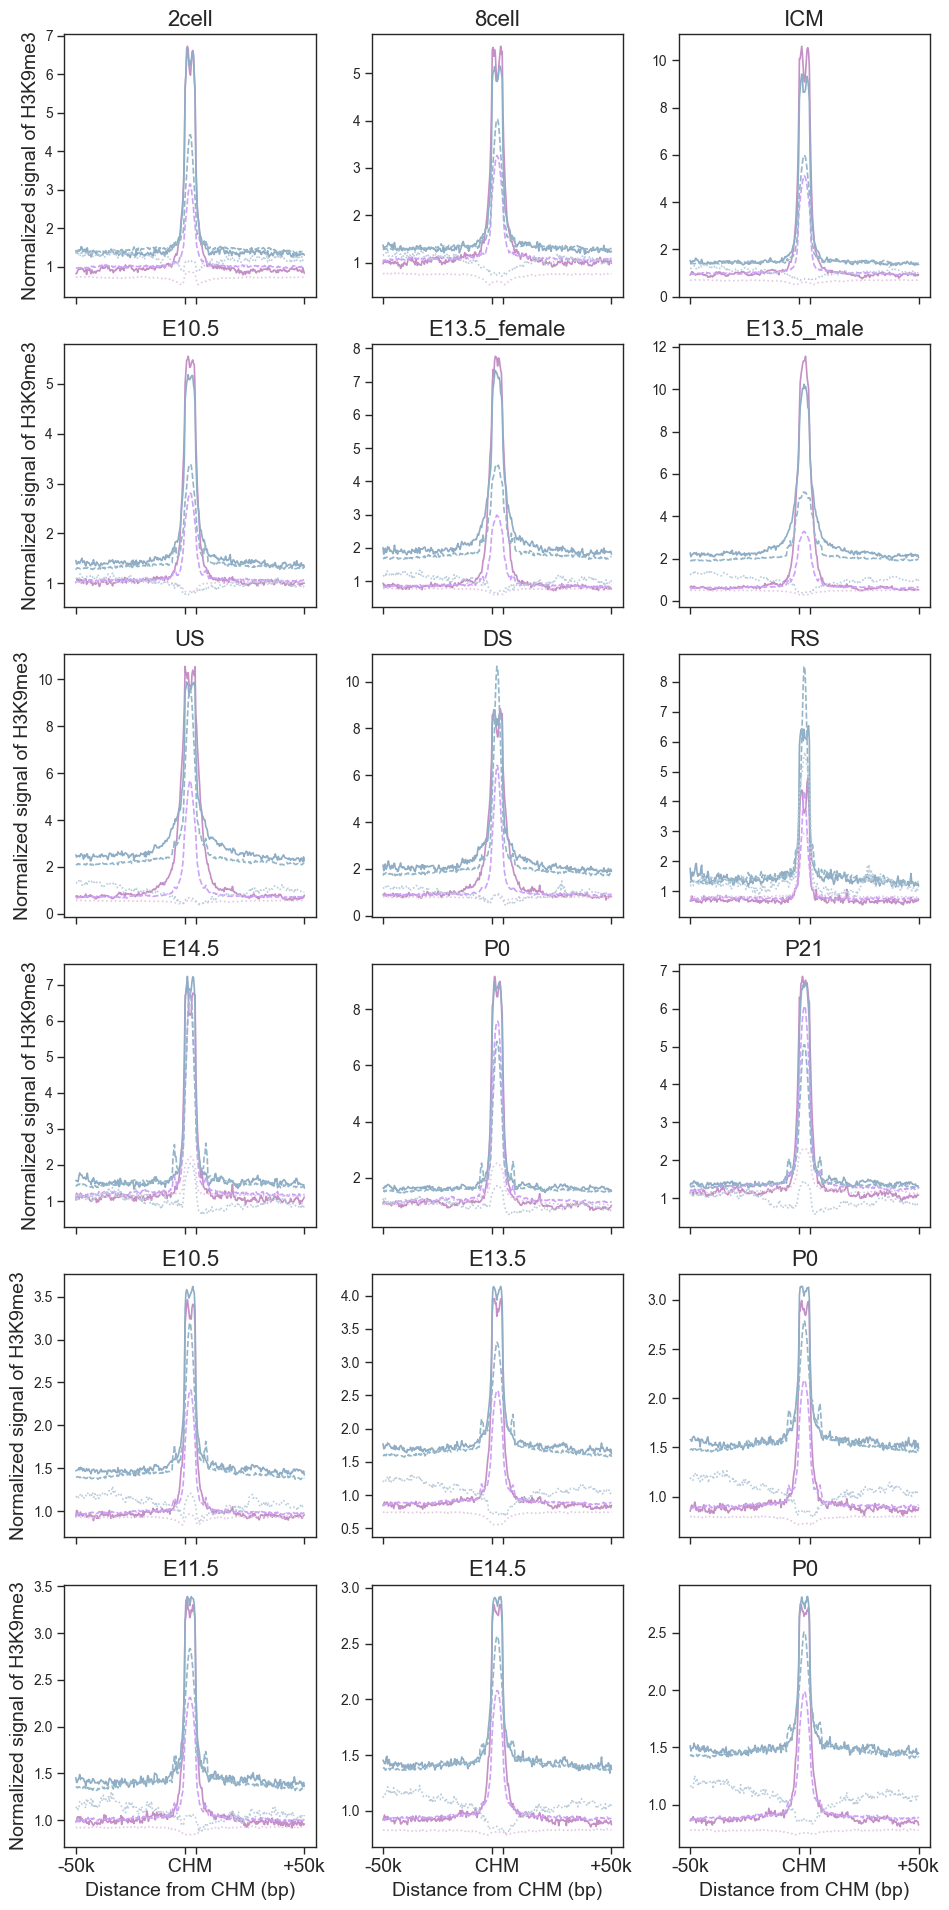

In [47]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 16,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 3, figsize=(6.4 * 1.5, 4.8 * 4), sharey = False, sharex = True, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_3_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_H3K9me3'
                for j,compart in enumerate(['A', 'B']) :
                    x = signal_AB_concat_dict_uni[span][label][compart].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict_uni[span][label][compart].mean(), k = 3)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=compart, color=colors_uni[j])
                    
                label = f'{process}_{stage}_H3K9me3_nonUniversalCHM'
                for j,compart in enumerate(['A', 'B']) :
                    x = signal_AB_concat_dict_nonUni[span][label][compart].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict_nonUni[span][label][compart].mean(), k = 3)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=compart, color=colors_nonUni[j], linestyle='dashed')

                label = f'{process}_{stage}_H3K9me3_nonCHM'
                for j,compart in enumerate(['A', 'B']) :
                    x = signal_AB_concat_dict_nonCHM[span][label][compart].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict_nonCHM[span][label][compart].mean(), k = 3)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=compart, color=colors_nonCHM[j], linestyle='dotted')

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance from CHM (bp)')

                if b == 0 :
                    ax.set_ylabel('Normalized signal of H3K9me3')
                ax.set_title(f'{stage}')

        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_K9_3stages_UniversalCHM_nonUniversalCHM_nonCHM_overlap_ABcompart_{str(span)[:-3]}k_5tissue_consistent.pdf', transparent=True)        


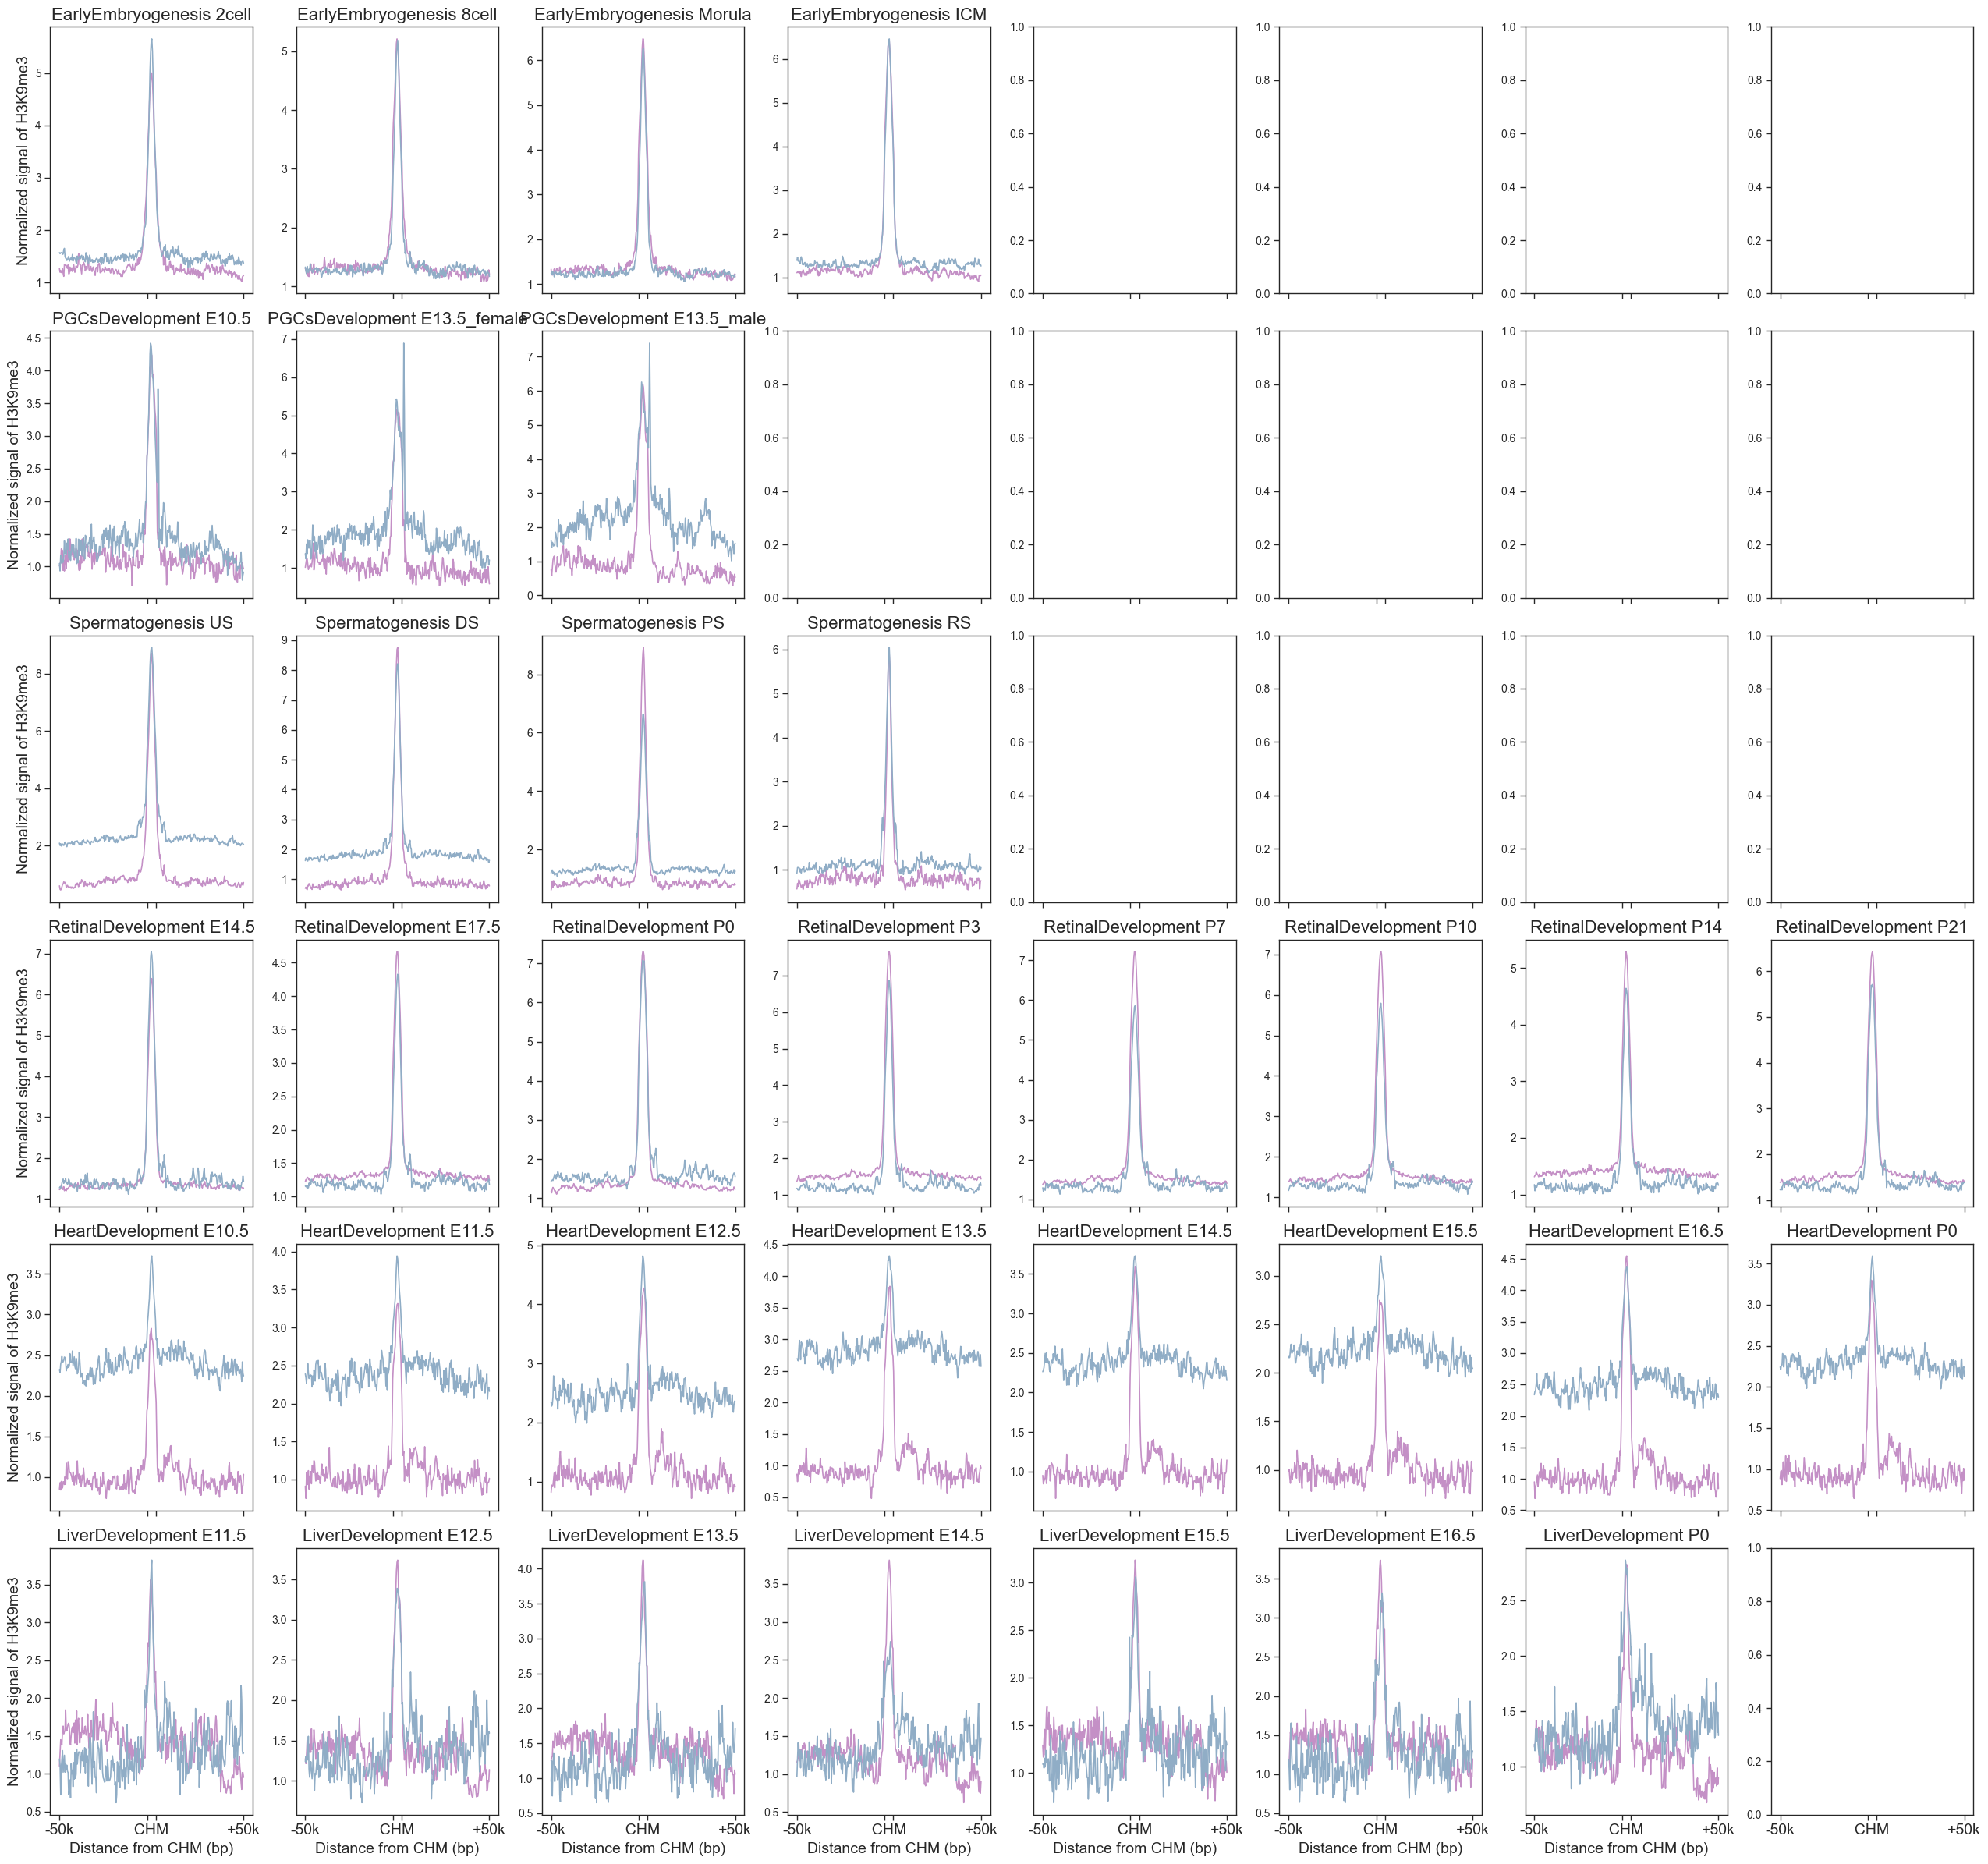

In [15]:
# from scipy.interpolate import make_interp_spline, BSpline
# with sns.axes_style('white', rc={
#         'xtick.bottom': True,
#         'ytick.left': True
# }), sns.plotting_context('paper',
#                          rc={
#                              'axes.titlesize': 16,
#                              'axes.labelsize': 14,
#                              'xtick.labelsize': 14,
#                              'ytick.labelsize': 10,
#                              'legend.fontsize': 8
#                          }):
    
#     for span in [50000] :    
#         fig, axes = plt.subplots(6, 8, figsize=(6.4 * 4, 4.8 * 5), sharey = False, sharex = True, tight_layout = True)  
#         for a,process in enumerate(stage_dict.keys()) :
#             for b,stage in enumerate(stage_dict[process]) : 
#                 ax = axes[a, b]
#                 label = f'{process}SpecificCHM_{stage}_K9'
#                 for j,compart in enumerate(['A', 'B']) :
#                     x = signal_AB_concat_dict[span][label][compart].columns
#                     xnew = np.linspace(x.min(), x.max(), 300) 
#                     spl = make_interp_spline(x, signal_AB_concat_dict[span][label][compart].mean(), k = 1)
#                     signal_smooth = spl(xnew)
#                     ax.plot(xnew, signal_smooth, label=compart, color=colors[j])

#                 ax.set_xticks([-span, 0, 5000, 5000+span])
#                 ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

#                 if a == (len(stage_dict.keys()) - 1) :
#                     ax.set_xlabel('Distance from CHM (bp)')

#                 if b == 0 :
#                     ax.set_ylabel('Normalized signal of H3K9me3')
#                 ax.set_title(f'{process} {stage}')

#                 # ax.set_ylim(0,1)

#         fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_K9_processSpecificCHM_overlap_ABcompart_{str(span)[:-3]}k_5tissue_consistent.pdf', transparent=True)        
